In [138]:
# adapted from https://pyro.ai/examples/prodlda.html
# imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import torch
import time

import math
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange

# Importing modules
import re

#plotting libraries!
import matplotlib.pyplot as plt
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

### Apply to movie set ###
#### end goal: ####
want to  map/group movies (doc id) to topics so we can look up a topic and find related movies or vice versa
#### what we have: ####
movie descriptions for ~9k movies from netflix titles database
#### plan: ####
- our LDA model takes in a matrix of token counts and outputs beta values
- need to convert what we have into a matrix of token counts using the CountVectorizer function
    - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [139]:
# import data and create relevant dfs
df = pd.read_csv("./netflix_titles.csv")
# df = pd.read_csv("./titles_sample.csv")
df['description'] = df['description'].map(lambda x: re.sub("([^\x00-\x7F])+","", x)) # from jessica's code
data = df['description'].to_numpy() 

# `max_df` removes common words - words with frequency higher than this across all documents
# `min_df` removes rare words - words that appear in less than min_df number of docs
# note: if min_df is too big, will get error in word cloud (i think because not enough data for all topics)
# max min_df i've found that works is 5
vectorizer = CountVectorizer(min_df=5, max_df=0.7, stop_words='english') # 1, 0.7
# docs is matrix of size M x N where M is number of movies, N is number of words in vocab
docs = torch.from_numpy(vectorizer.fit_transform(data).toarray())

# creates df with words and indices corresponding to words 
# used to convert betas back to words in word cloud plots
vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index

print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))

Dictionary size: 4663
Corpus size: torch.Size([8807, 4663])


In [140]:
# setting global variables related to LDA computation
smoke_test=False
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 20 if not smoke_test else 3
docs = docs.float().to(device)
batch_size = 32
learning_rate = 1e-3
num_epochs = 50 if not smoke_test else 1

In [141]:
# training 
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=100 if not smoke_test else 10,
    dropout=0.2
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(docs.shape[0] / batch_size)) if not smoke_test else 1

start = time.perf_counter()
bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = docs[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs)
        running_loss += loss / batch_docs.size(0)

    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))
end = time.perf_counter()
print(f"Finished in {(end - start)/60:0.4f} minutes")

100%|██████████| 50/50 [01:40<00:00,  2.01s/it, epoch_loss=2.07e+04]

Finished in 1.6752 minutes


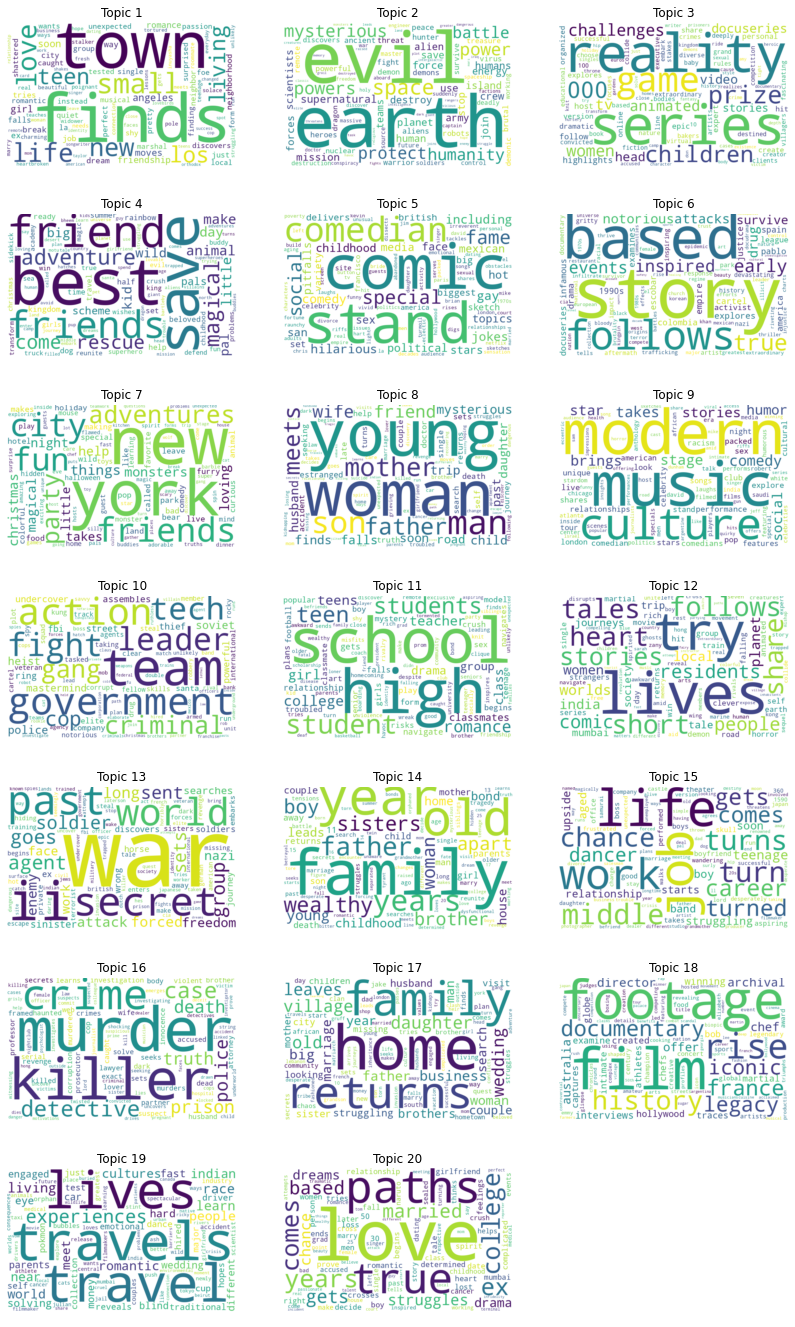

In [142]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True) # sorts betas by descending order
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, v[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

beta = prodLDA.beta()
fig, axs = plt.subplots(7, 3, figsize=(14, 24))
for n in range(beta.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud(beta[n], axs[i, j], vocab, n)
axs[-1, -1].axis('off');

plt.show()